In [36]:
import os
import pandas as pd
import pickle
import collections
import matplotlib.pyplot as plt
from statistics import  mean
import math
import time
from typing import Union
import tqdm
%matplotlib inline

In [2]:
HOME = os.environ['HOME']

## Creating Dataframe

In [3]:
def create_df(dpath:str)->pd.DataFrame:
    '''
    Creates a pandas dataframe from all the 
    pickled files
    '''
    data = pd.DataFrame(columns=['Time','Name','Model',
                                'GPS','Speed','BS'])

    for count,filename in enumerate(os.listdir(dpath)):
        ind = count
        with open(dpath+f'/{filename}','rb') as a:
            data.at[ind,'Time'] = pickle.load(a)
            data.at[ind,'Name'] = pickle.load(a)
            data.at[ind,'Model'] = pickle.load(a)
            data.at[ind,'GPS'] = pickle.load(a)
            data.at[ind,'Speed'] = pickle.load(a)
            data.at[ind,'BS'] = pickle.load(a)
        
        if (count+1)%1000 == 0:
            print(f'{count+1} samples has been added to dataframe')

    return data


In [14]:
try: 
    data = pd.read_pickle(f'{HOME}/webots_code/data/final/gps.pkl')
    print(f'Preprocessed dataframe already present')
except:
    # data = create_df(dpath)
    print(f'DataFrame does not exist')

Preprocessed dataframe already present


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14902 entries, 0 to 14901
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Time    14902 non-null  object
 1   Name    14902 non-null  object
 2   Model   14902 non-null  object
 3   GPS     14902 non-null  object
 4   Speed   14902 non-null  object
 5   Lidar   14902 non-null  object
 6   BS      14902 non-null  object
dtypes: object(7)
memory usage: 931.4+ KB


In [16]:
ncars = len(data['Name'].unique())

## Distribution of samples 

<BarContainer object of 57 artists>

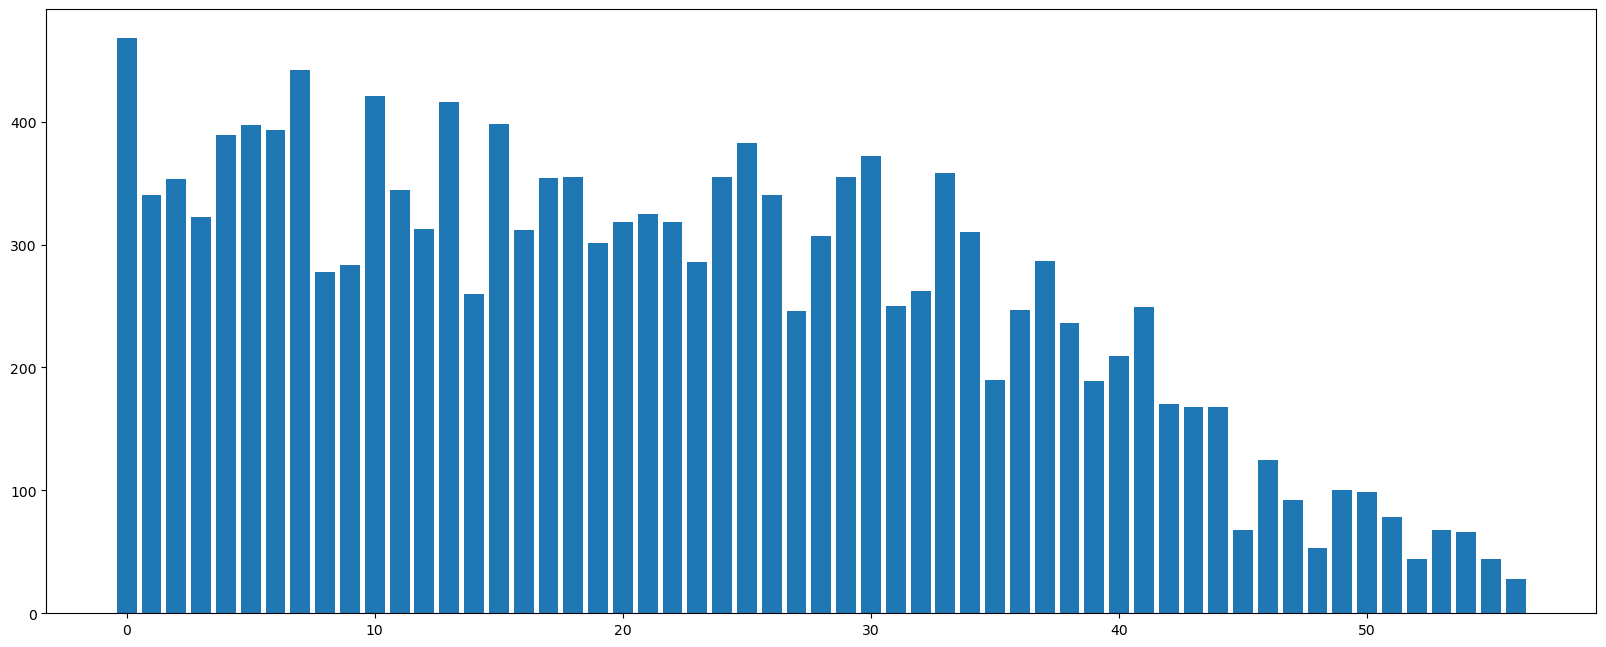

In [17]:
# Number of samples per car
car_dist = data['Name'].value_counts().to_dict()
#Sorting into list
per_car = [car_dist[f'SUMO vehicle {i}'] for i in range(0,len(data['Name'].unique()))]

plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100 
plt.bar(range(0,len(data['Name'].unique())),per_car)

## Average Speed and speed distribution

In [18]:
speed = dict()
speed_dist = [0]*(round(data['Speed'][data['Speed']<100].max())+1)
for i in data.index.values:
    if data.at[i,'Speed'] > 100.00:
        print('Unusually high speed:',data.at[i,'Speed'],'Skipping')
        continue
    if data.at[i,'Name'] in speed.keys():
        speed[data.at[i,'Name']].append(data.at[i,'Speed'])
    else:
        speed[data.at[i,'Name']] = list()
        speed[data.at[i,'Name']].append(data.at[i,'Speed'])
    speed_dist[round(data.at[i,'Speed'])]+=1

### Speed Distribution

Max speed is 48.34830694641104


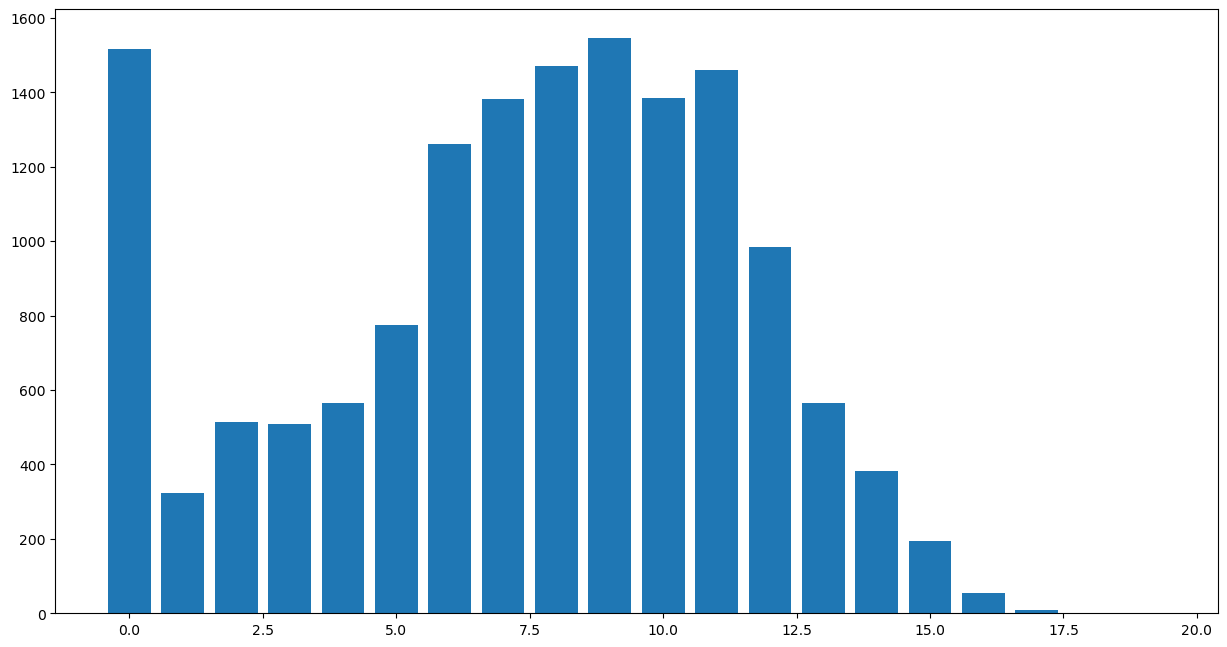

In [19]:
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.dpi'] = 100
plt.bar(range(20),speed_dist[:20])
print('Max speed is',data['Speed'][data['Speed']<100].max())

In [20]:
avg_speed = list()
for i in range(len(data['Name'].unique())):
    avg_speed.append(mean(speed[f'SUMO vehicle {i}']))

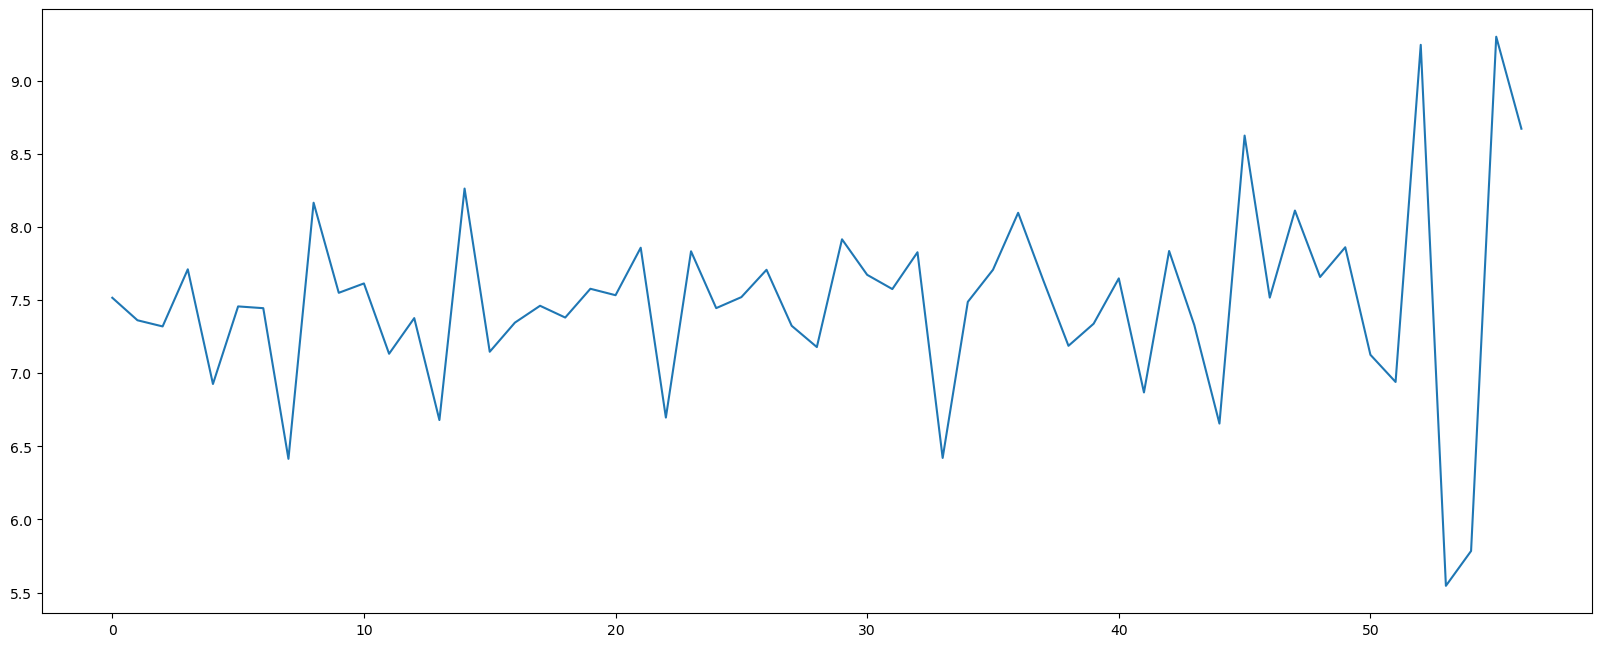

In [21]:
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100
plt.plot(range(ncars),avg_speed)

## Surrounding vehicles

### For each sample
Calculating surrounding vehciles for each sample

In [71]:
timestep = 0.128
gpath = f'{HOME}/webots_code/data/final/samples'
lrange = 120

#Creating new column for veh count
veh_range = [0]*len(data)

In [72]:
# Determining the distance between car and transmitter in meter
# TO-DO : Consider height while calculating distance
def dist_gps(gps1, gps2):
    lat1, lon1, _ = gps1
    lat2, lon2, _ = gps2
    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + \
        math.cos(phi_1) * math.cos(phi_2) * \
        math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

In [73]:
def read_gps(gpath)-> Union[pd.DataFrame]:
    '''
    Read all the GPS dataset and store
    it in RAM, for faster exec
    '''
    gps_pd = []
    for filename in os.listdir(gpath):
        gps_pd.append(pd.read_pickle(
                        gpath+f'/{filename}'))
    
    return gps_pd

In [74]:
gps_pd = read_gps(gpath)
print(len(gps_pd))

57


In [52]:
gps_entry = gps_pd[0]

entry = gps_entry[
                    ((data.at[0,'Time'] - timestep) < gps_entry['Time']) &
                    (gps_entry['Time'] <= data.at[0,'Time'])
                    ]
print(gps_entry.head(),data.at[0,'Time'],entry)

      Time            Name           Model  \
0  133.824  SUMO vehicle 4  Citroen C-Zero   
1  135.872  SUMO vehicle 4  Citroen C-Zero   
2   137.92  SUMO vehicle 4  Citroen C-Zero   
3  139.968  SUMO vehicle 4  Citroen C-Zero   
4  141.888  SUMO vehicle 4  Citroen C-Zero   

                                                 GPS      Speed  \
0  [[38.89448376285537, -77.0737845525893, 0.3349...   6.481395   
1  [[38.894574924525216, -77.07365297018046, 0.33...   7.620457   
2  [[38.894657769551934, -77.07344713184817, 0.33...  11.970163   
3  [[38.894713812862484, -77.07321101165967, 0.33...  12.088371   
4  [[38.894779097132144, -77.07298437232441, 0.33...  10.256725   

                     Lidar                                                 BS  
0  SUMO vehicle 4133.8.npz  [[38.89502, -77.07303, 5.0], [38.89442, -77.07...  
1  SUMO vehicle 4135.9.npz  [[38.89502, -77.07303, 5.0], [38.89442, -77.07...  
2  SUMO vehicle 4137.9.npz  [[38.89502, -77.07303, 5.0], [38.89442, -77.07...  


In [64]:
gps_pd[0][(604<= gps_pd[0]['Time']) & (gps_pd[0]['Time'] <= 606)]

,Time,Name,Model,GPS,Speed,Lidar,BS
24,605.12,SUMO vehicle 4,Citroen C-Zero,"[[38.89508709795325, -77.07317136459565, 0.334...",0.226141,SUMO vehicle 4605.1.npz,"[[38.89502, -77.07303, 5.0], [38.89442, -77.07..."


In [70]:
(gps_pd[0].at[25,'Time'] - gps_pd[0].at[24,'Time'])/0.128

16.000000000000014

In [63]:
605.12 + 0.128

605.248

In [75]:
#Iterating over all the vehicle GPS data
start = time.time()
veh_dist = list()
for i in tqdm.tqdm_notebook(data.index.values):
    siml_time = data.at[i,'Time']
    i_dist = list()
    for gps_entry in gps_pd: 
        # Checking for the position of the vehicle in that timestep
        entry = gps_entry[
                    ((data.at[i,'Time'] - timestep) < gps_entry['Time']) &
                    (gps_entry['Time'] <= data.at[i,'Time'])
                    ]
        
        
        if entry.empty : 
            continue
        

        if len(entry) > 1:
            entry = entry[entry['Time']==siml_time]
            
        # Calculating distance between vehicles
        dist = dist_gps(data.at[i,'GPS'][1],entry['GPS'].values[0][1])
        dist = round(dist,2)
        if dist < lrange and dist!=0:
            veh_range[i] +=1         #For number of vehicles in range
            i_dist.append(dist) #Capturing the distance of each vehicle
    
    veh_dist.append(i_dist)

/home/mohit/anaconda3/envs/webots_37/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/14902 [00:00<?, ?it/s]

In [17]:
# # Saving dataframe
# savepath = f'{HOME}/webots_code/data/final/stats_pd.pkl'
# data.to_pickle(savepath)

In [18]:
# data

In [77]:
data['veh_range'] = veh_range
data['veh_dist'] = veh_dist

### Load pre processed data

<BarContainer object of 5 artists>

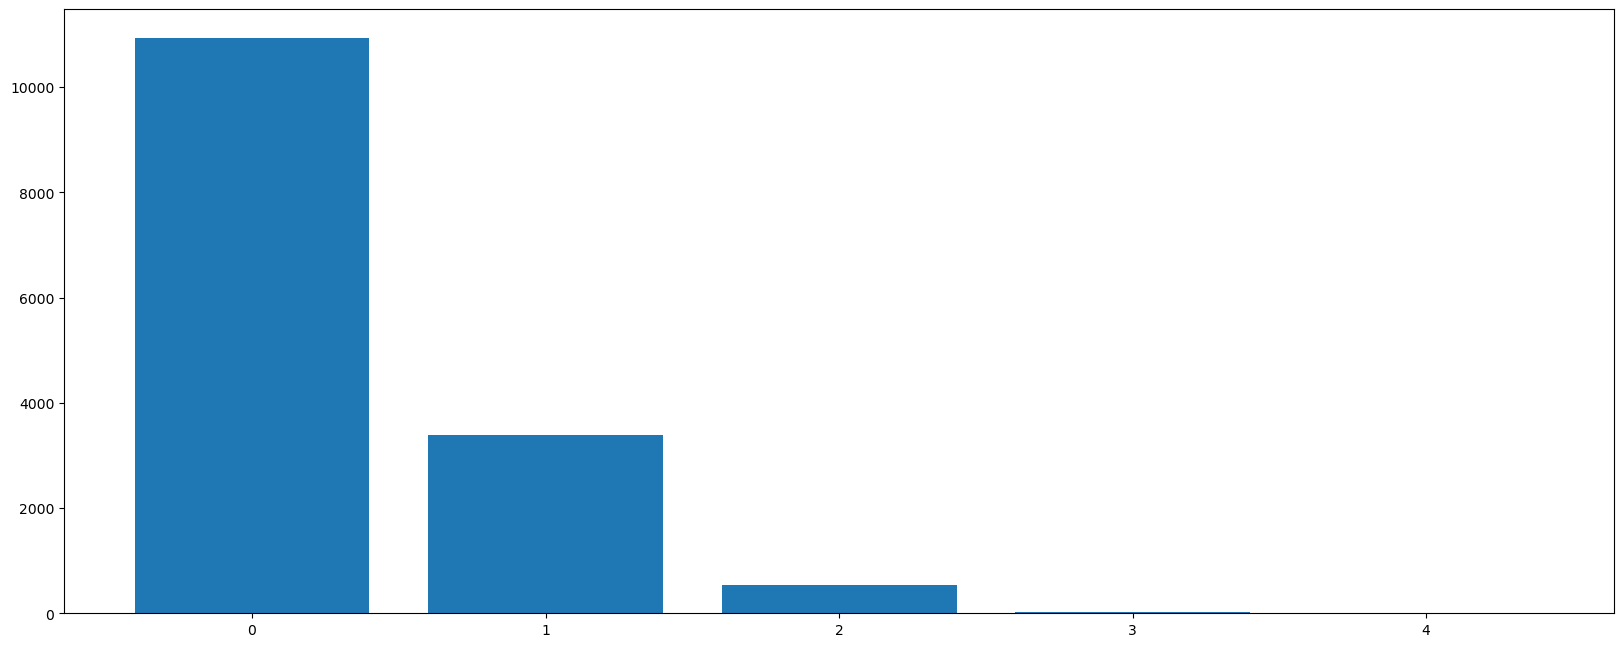

In [78]:
occr = [0]*(data['veh_range'].max()+1)

for i in data.index.values:
    occr[data.at[i,'veh_range']]+=1

plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100
plt.bar(range(data['veh_range'].max()+1),occr)

/home/mohit/anaconda3/envs/webots_37/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/14902 [00:00<?, ?it/s]

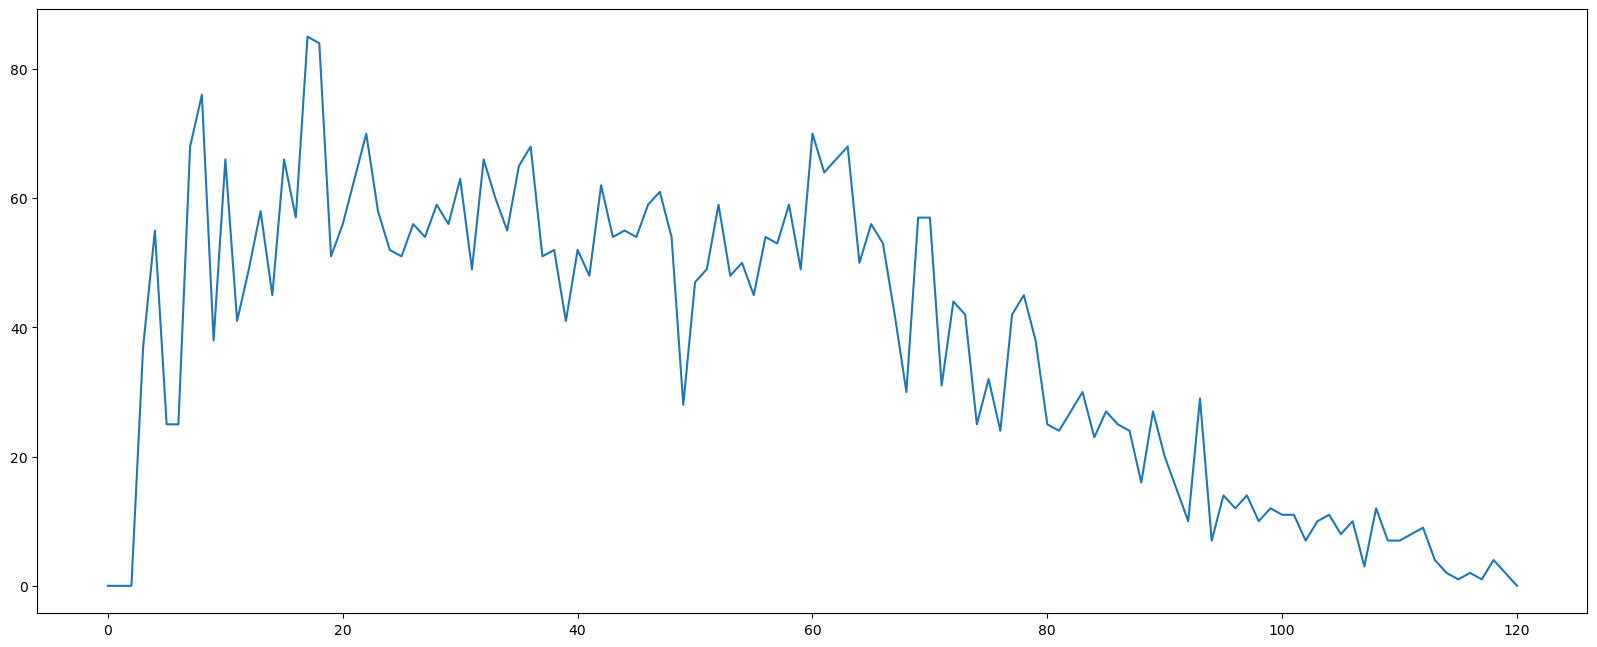

In [79]:
dist = [0]*121
start = time.time()
for i in tqdm.tqdm_notebook(data.index.values):
    for j in data.at[i,'veh_dist']:
        dist[int(j)] +=1
        
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100
plt.plot(range(0,121),dist)

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14902 entries, 0 to 14901
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Time       14902 non-null  object
 1   Name       14902 non-null  object
 2   Model      14902 non-null  object
 3   GPS        14902 non-null  object
 4   Speed      14902 non-null  object
 5   Lidar      14902 non-null  object
 6   BS         14902 non-null  object
 7   veh_range  14902 non-null  int64 
 8   veh_dist   14902 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.6+ MB
